In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class Bandit:
    def __init__(self, k_arm=10, true_reward=0.0):
        self.k = k_arm
        self.true_reward = true_reward
        self.actions_values = None
        self.best_action = None

    def reset(self):
        self.actions_values = np.random.randn(self.k) + self.true_reward
        self.best_action = np.argmax(self.actions_values)

    def pull(self, action: int) -> float:
        return np.random.randn() + self.actions_values[action]

class Agent:
    def __init__(self, k_arm=10, epsilon=0.0, sample_averages=True):
        self.k = k_arm
        self.epsilon = epsilon
        self.sample_averages = sample_averages
        self.q_estimation = None
        self.action_count = None
        self.available_actions = np.arange(self.k)

    def reset(self):
        self.q_estimation = np.zeros(self.k)
        self.action_count = np.zeros(self.k)

    def act(self) -> int:
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.available_actions)
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def learn(self, action: int, reward: float):
        self.action_count[action] += 1
        if self.sample_averages:
            alpha = 1.0 / self.action_count[action]
            self.q_estimation[action] += alpha * (reward - self.q_estimation[action])

def simulate(runs, time, agents, envs):
    rewards = np.zeros((len(agents), runs, time))
    best_action_counts = np.zeros_like(rewards)

    for i, (agent, env) in enumerate(zip(agents, envs)):
        for r in range(runs):
            env.reset(); agent.reset()
            for t in range(time):
                action = agent.act()
                reward = env.pull(action)
                agent.learn(action, reward)
                rewards[i, r, t] = reward
                best_action_counts[i, r, t] = (action == env.best_action)

    return best_action_counts.mean(axis=1), rewards.mean(axis=1)

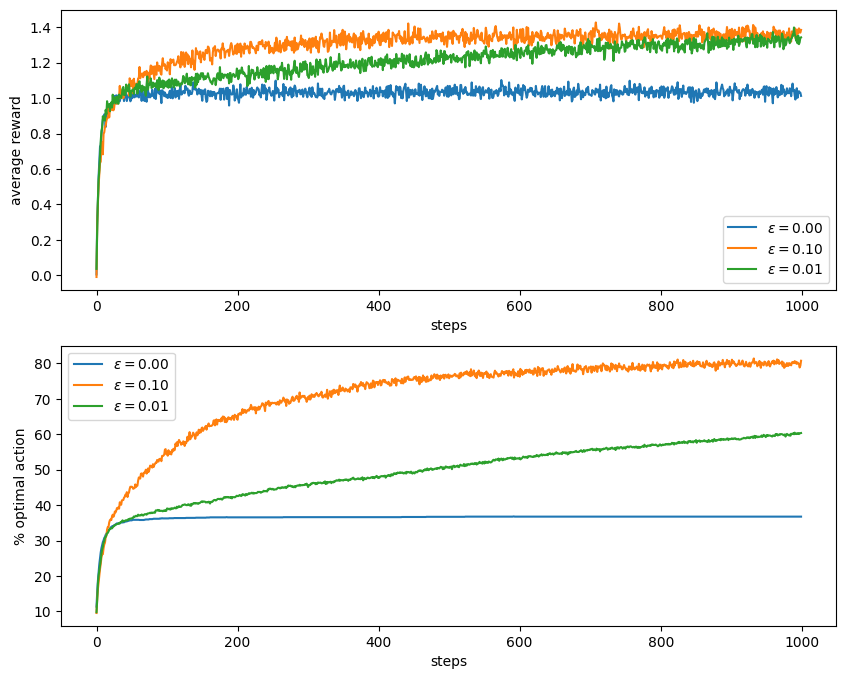

In [3]:
runs = 2000
time = 1000
epsilons = [0.0, 0.1, 0.01]
agents = [Agent(k_arm=10, epsilon=eps) for eps in epsilons]
envs   = [Bandit(k_arm=10, true_reward=0.0) for _ in epsilons]

plt.figure(figsize=(10, 8))

best_action_counts, rewards = simulate(runs, time, agents, envs)

plt.subplot(2, 1, 1)
for eps, rew in zip(epsilons, rewards):
    plt.plot(rew, label=f"$\\epsilon = {eps:.2f}$")
plt.xlabel("steps"); plt.ylabel("average reward"); plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(100 * counts, label=f"$\\epsilon = {eps:.2f}$")
plt.xlabel("steps"); plt.ylabel("% optimal action"); plt.legend()
plt.show()